<font size="+2"><strong>Apartment Price Prediction in Buenos Aires, Capital Federal: A Machine Learning Approach for Real Estate Valuation</strong></font>

### Abstract

This project focuses on developing a robust machine learning model to accurately predict apartment prices in the Capital Federal autonomous city of Buenos Aires, Argentina. Leveraging a comprehensive dataset sourced from Properati, the study addresses the inherent complexities of real estate valuation by employing a rigorous data-driven methodology. The initial phase involved extensive data wrangling, encompassing subsetting for relevant apartment sales under $400,000 USD, handling missing values, engineering geographical features, and implementing outlier detection and clipping for critical variables like `surface_covered_in_m2`. Exploratory Data Analysis (EDA) provided crucial insights into the distributions of price, covered area, and the spatial impact of latitude, longitude, and neighborhood (`place_name`) on property values, highlighting the non-linear and categorical influences of location. A machine learning pipeline was then constructed, incorporating imputation and scaling for numerical features, and one-hot encoding for categorical variables. Multiple regression models, including Linear Regression, Ridge, Lasso, Random Forest Regressor, and Gradient Boosting Regressor, were trained and evaluated. Hyperparameter tuning was systematically performed using GridSearchCV to optimize model performance. Preliminary results indicate that the Random Forest Regressor consistently delivers the lowest Mean Absolute Error (MAE) and highest R-squared (R²) on the validation set, demonstrating its superior ability to capture the intricate relationships within the real estate market data. This work underscores the efficacy of machine learning in providing data-driven estimations for real estate valuation.

### 1. Introduction

The real estate market is a dynamic and complex domain, significantly influenced by a myriad of factors including location, property characteristics, economic conditions, and market trends. Accurate property valuation is critical for a diverse range of stakeholders, from individual buyers and sellers to real estate agents, investors, and financial institutions. Traditional appraisal methods often rely on expert judgment and comparable sales, which can be time-consuming and sometimes lack the precision afforded by large-scale data analysis. In an increasingly data-rich environment, machine learning offers a powerful alternative for developing more objective, efficient, and accurate predictive models.

This project aims to address the challenge of apartment price prediction specifically within the Capital Federal area of Buenos Aires, Argentina. As a vibrant and diverse urban center, its real estate market presents unique patterns and nuances. The objective is to leverage a comprehensive dataset from Properati, a leading real estate portal, to build and evaluate machine learning models capable of providing reliable apartment price estimations.

The project unfolds through a structured methodology, beginning with an intensive data wrangling phase. This involves cleaning raw data, filtering for relevant properties (apartments under a specific price threshold in Capital Federal), handling missing information, and performing essential feature engineering and outlier management to prepare a high-quality dataset. Subsequently, Exploratory Data Analysis (EDA) will be conducted to uncover underlying patterns, distributions, and relationships between various property features (such as covered area, geographical coordinates, and neighborhood) and the target variable (price). This deep understanding of the data will inform the model selection and feature engineering strategies.

Finally, a robust machine learning pipeline will be developed to preprocess the features and train several regression models, including linear and ensemble-based approaches. Hyperparameter tuning will be rigorously applied to optimize each model's performance, with evaluation metrics like Mean Absolute Error (MAE) and R-squared (R²) guiding the selection of the most effective predictive solution. Through this systematic approach, the project seeks to demonstrate the practical application of machine learning in enhancing the accuracy and efficiency of real estate valuation in the Buenos Aires market.

### 2. Import Data

In [ ]:
%%capture

!pip install category_encoders

In [ ]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


from geopy.distance import geodesic
from sklearn.cluster import KMeans
from category_encoders.one_hot import OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

warnings.simplefilter(action="ignore", category=FutureWarning)

In [ ]:
def wrangle (filepath):
    # 1. Import CSV
    df = pd.read_csv(filepath, low_memory=False)

    # 2. Subset data: Apartments in "Capital Federal", less than 400,000 USD
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price].copy() # .copy() to avoid SettingWithCopyWarning

    return df

df = wrangle("/content/properati-AR-2016-11-01-properties-sell.csv")
print(df.shape)
print(df.info())
df.head()

(18157, 24)
<class 'pandas.core.frame.DataFrame'>
Index: 18157 entries, 1 to 145745
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   created_on                  18157 non-null  object 
 1   operation                   18157 non-null  object 
 2   property_type               18157 non-null  object 
 3   place_name                  18157 non-null  object 
 4   place_with_parent_names     18157 non-null  object 
 5   geonames_id                 17467 non-null  float64
 6   lat-lon                     17401 non-null  object 
 7   lat                         17401 non-null  float64
 8   lon                         17401 non-null  float64
 9   price                       18157 non-null  float64
 10  currency                    18157 non-null  object 
 11  price_aprox_local_currency  18157 non-null  float64
 12  price_aprox_usd             18157 non-null  float64
 13  surface_total_in_m2    

,created_on,operation,property_type,place_name,place_with_parent_names,geonames_id,lat-lon,lat,lon,price,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
1,2012-10-10,sell,apartment,Villa Crespo,|Argentina|Capital Federal|Villa Crespo|,3427458.0,"-34.6036844,-58.3815591",-34.603684,-58.381559,83000.0,...,40.0,2075.0,2075.000000,1.0,2.0,300,http://villa-crespo.properati.com.ar/13tz_vent...,"2 AMBIENTES, VENTA, VILLA CRESPO1ER PISO POR E...",DEPARTAMENTO EN VENTA,https://thumbs-cf.properati.com/8/ujkSk81S7fhu...
186,2013-05-15,sell,apartment,Parque Centenario,|Argentina|Capital Federal|Parque Centenario|,NaN,"-34.60881,-58.4414539",-34.608810,-58.441454,150000.0,...,NaN,NaN,NaN,NaN,2.0,NaN,http://parque-centenario.properati.com.ar/70f7...,"Venta - Departamento - Argentina, Buenos Aires...",Departamento en Venta ubicado en Parque Centen...,https://thumbs-cf.properati.com/1/QecQaJuS2qQ2...
195,2013-05-20,sell,apartment,Villa Devoto,|Argentina|Capital Federal|Villa Devoto|,3427451.0,"-34.598942,-58.500647",-34.598942,-58.500647,324720.0,...,140.0,NaN,2319.428571,8.0,4.0,NaN,http://villa-devoto.properati.com.ar/73iz_vent...,Corredor Responsable: Patricia Maria Sodor - C...,ULTIMA UNIDAD DE 4 AMBIENTES!,https://thumbs-cf.properati.com/0/G63ECCkemzvp...
197,2013-05-20,sell,apartment,Chacarita,|Argentina|Capital Federal|Chacarita|,3435506.0,"-34.585106,-58.462549",-34.585106,-58.462549,80000.0,...,55.0,NaN,1454.545455,9.0,2.0,NaN,http://chacarita.properati.com.ar/79qp_venta_d...,Corredor Responsable: Jorge Salafia - CUCICBA ...,DIVINO MONOAMB EN TRIUNVIRATO PESOSSS!!!! FINA...,https://thumbs-cf.properati.com/3/eRJkRtFUzcGu...
198,2013-05-20,sell,apartment,Palermo,|Argentina|Capital Federal|Palermo|,3430234.0,"-34.603723,-58.381593",-34.603723,-58.381593,105000.0,...,33.0,NaN,3181.818182,NaN,2.0,NaN,http://palermo.properati.com.ar/79tx_venta_dep...,Corredor Responsable: Jorge Salafia - CUCICBA ...,Monoambiente Posesion inmediata,https://thumbs-cf.properati.com/0/87l8vNaisEZw...


### 3. Data Preprocessing & Feature Selection

#### 3.1 Initial Data Filtering & Handling Missing Values


Before separating features and target, an initial filtering step was applied during data loading (in the `wrangle` function) to focus the analysis on specific property types and locations:
* **Property Type:** Filtered to include only `apartment` properties.
* **Location:** Filtered to `Capital Federal` region.
* **Price:** Properties with `price_aprox_usd` less than 400,000 USD were selected to focus on a more relevant and common price range, and to mitigate the impact of extreme outliers.

Following this, columns with a very high percentage of missing values were dropped, as imputation for such high counts might introduce too much noise or bias.

* **`floor`**: Dropped due to a high percentage of missing values (e.g., >80%). While potentially useful, its widespread absence would make reliable imputation challenging without significant domain knowledge or advanced techniques.
* **`expenses`**: Also dropped due to a high percentage of missing values (e.g., >80%), making it unreliable for direct use or imputation.

#### 3.2 Handling Non-Informative & High Cardinality Features


Several columns were identified as non-informative, constant after initial subsetting, or unsuitable for direct use in a numerical model due to their nature (e.g., text, URLs, high cardinality identifiers).

* **Constant Features (after subsetting):**
    * **`place_with_parent_names`**: After filtering for "Capital Federal", this column became redundant as all remaining entries would be "Capital Federal|...".
    * **`operation`**: After filtering for properties from the 'sell' dataset, this column became constant ("sell").
    * **`property_type`**: After filtering for "apartment", this column became constant ("apartment").
    * **`currency`**: After filtering by `price_aprox_usd`, this column became constant ("USD").
* **Metadata / High Cardinality Identifiers / Text:**
    * **`properati_url`**: A unique URL for each listing; acts as an identifier and holds no predictive power for price.
    * **`title`**: Free-form text description; requires Natural Language Processing (NLP) to extract features, which is outside the scope of this numerical prediction project.
    * **`description`**: Similar to `title`, long-form text that requires NLP.
    * **`image_thumbnail`**: A URL to an image; requires Computer Vision if used, not relevant for this numerical model.
    * **`geonames_id`**: An external geographical identifier; while `latitude` and `longitude` are retained, this specific ID is not directly useful as a feature.
    * **`created_on`**: A datetime column; could be engineered into features like 'listing age' or 'season', but dropped for simplicity to focus on core property attributes in this iteration.

#### 3.3 Dropping Leaky Features



"Leaky" features are those that contain information about the target variable that would not be available at the time of prediction, or are direct derivations of the target. Including them would lead to unrealistically optimistic model performance.

* **`price`**: This likely represents the original price in local currency, or a raw unadjusted price. Since `price_aprox_usd` is our target, `price` is a direct (or near-direct) conversion and thus highly leaky.
* **`price_aprox_local_currency`**: This is simply `price_aprox_usd` converted to local currency; a direct leak.
* **`price_per_m2`**: This feature is calculated as `price / surface_area`. Since `price` is directly related to our target (`price_aprox_usd`), `price_per_m2` becomes a direct leak.
* **`price_usd_per_m2`**: This is even more directly derived from our target (`price_aprox_usd / surface_area`). It's a severe form of data leakage.

#### 3.4 Handling Multicollinearity



Multicollinearity occurs when independent variables in a model are correlated with each other. While tree-based models are more robust to multicollinearity than linear models, it can still sometimes affect model stability or interpretability. Based on the correlation heatmap from EDA, certain features exhibited high correlation.

* **`surface_total_in_m2`**: This feature, representing the total surface area, was found to be highly correlated with `surface_covered_in_m2` (the covered living area). `surface_covered_in_m2` was chosen to be retained as it often more directly reflects the usable living space and is typically a stronger predictor.
* **`rooms`**: This feature often correlates strongly with total area (`surface_covered_in_m2`). To reduce redundancy and simplify the model without losing much information (as area often implicitly captures "rooms"), `rooms` was dropped.

In [ ]:
def wrangle(filepath):
    """
    Wrangle raw property data from a CSV file into a clean DataFrame
    suitable for house price prediction.

    Steps include:
    - Loading data from CSV.
    - Subsetting to apartments in "Capital Federal" below 400,000 USD.
    - Handling missing values by dropping specific columns with high null counts.
    - Dropping non-informative, constant, or leaky columns.
    - Engineering `latitude` and `longitude` from the `lat-lon` string column.
    - Handling multicollinearity by dropping one of highly correlated features.
    - Dropping other non-informative/identifier columns.

    Args:
        filepath (str): The path to the CSV file containing property data.

    Returns:
        pd.DataFrame: A cleaned DataFrame ready for further EDA and modeling.
    """
    # 1. Import CSV
    df = pd.read_csv(filepath, low_memory=False)

    # 2. Subset data: Apartments in "Capital Federal", less than 400,000 USD
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price].copy()

    # 3. Drop features with high null counts (e.g., > 50% missing values)
    df = df.drop(columns=["floor", "expenses"])

    # 4. Drop low/high cardinality categorical variables and constant features
    df = df.drop(columns=[
        "place_with_parent_names",
        "operation",
        "property_type",
        "currency",
        "properati_url",
        "title",
        "description",
        "image_thumbnail"
    ])

    # 5. Drop Leaky columns (derived from or directly related to the target 'price_aprox_usd')
    df = df.drop(columns=[
        "price",
        "price_aprox_local_currency",
        "price_per_m2",
        "price_usd_per_m2"
    ])

    # 6. Engineer Latitude and Longitude from 'lat-lon'
    df = df.drop(columns=['lat-lon'])

    # 7. Drop columns with multicollinearity (based on EDA and heatmap observation)
    df = df.drop(columns=["surface_total_in_m2", "rooms"])

    # 8. Drop other non-informative/identifier columns
    df = df.drop(columns=["created_on", "geonames_id"])

    return df

In [ ]:
df = wrangle("/content/properati-AR-2016-11-01-properties-sell.csv")
df.head()

,place_name,lat,lon,price_aprox_usd,surface_covered_in_m2
1,Villa Crespo,-34.603684,-58.381559,83000.0,40.0
186,Parque Centenario,-34.608810,-58.441454,150000.0,NaN
195,Villa Devoto,-34.598942,-58.500647,324720.0,140.0
197,Chacarita,-34.585106,-58.462549,80000.0,55.0
198,Palermo,-34.603723,-58.381593,105000.0,33.0


### 4. Exploring Data Analysis

#### 4.1 General Information

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18157 entries, 1 to 145745
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   place_name             18157 non-null  object 
 1   lat                    17401 non-null  float64
 2   lon                    17401 non-null  float64
 3   price_aprox_usd        18157 non-null  float64
 4   surface_covered_in_m2  16666 non-null  float64
dtypes: float64(4), object(1)
memory usage: 851.1+ KB


In [ ]:
df.describe()

,lat,lon,price_aprox_usd,surface_covered_in_m2
count,17401.000000,17401.000000,18157.000000,16666.000000
mean,-34.579433,-58.438227,143032.918841,63.495800
std,1.071812,0.959194,75598.256180,489.586005
min,-38.416097,-99.232744,0.000000,0.000000
25%,-34.618425,-58.463040,88800.000000,37.000000
50%,-34.600683,-58.435764,120000.000000,49.000000
75%,-34.579717,-58.405353,175000.000000,71.000000
max,38.115688,13.361267,399000.000000,62034.000000


In [ ]:
df.isnull().sum() / len(df)

,0
place_name,0.000000
lat,0.041637
lon,0.041637
price_aprox_usd,0.000000
surface_covered_in_m2,0.082117


#### 4.2 Target Variable Distribution (Histogram + Log Scale)

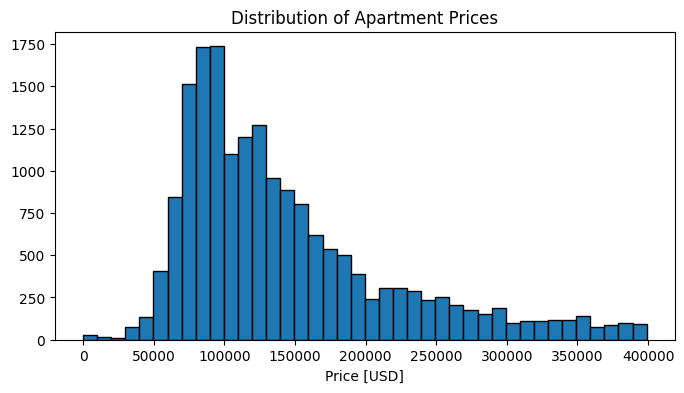

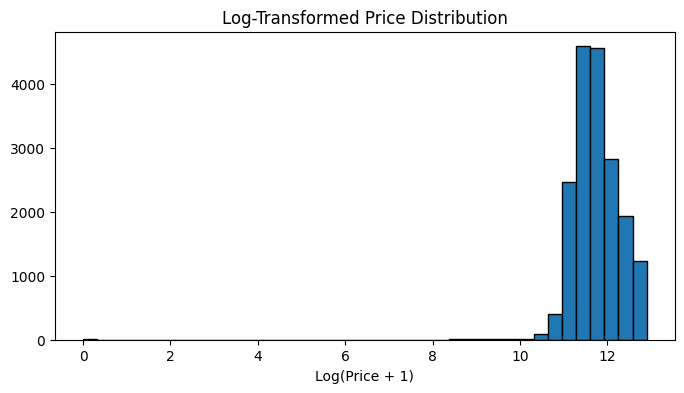

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(df["price_aprox_usd"], bins=40, edgecolor="black")
plt.xlabel("Price [USD]")
plt.title("Distribution of Apartment Prices")
plt.show()

# Log-transformed view
plt.figure(figsize=(8, 4))
plt.hist(np.log1p(df["price_aprox_usd"]), bins=40, edgecolor="black")
plt.xlabel("Log(Price + 1)")
plt.title("Log-Transformed Price Distribution")
plt.show()

#### 4.3 Distribution of Apartment Sizes (Surface Covered)

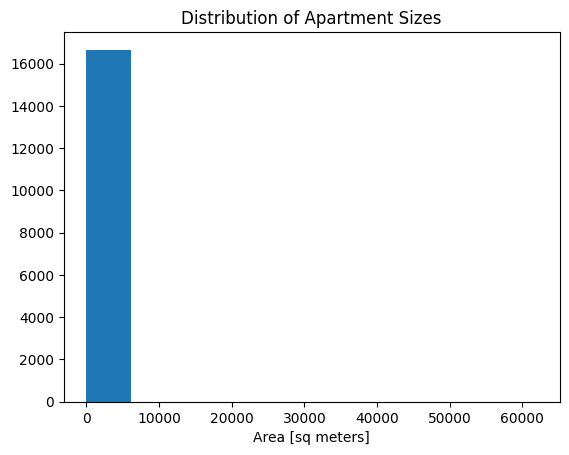

In [ ]:
plt.hist(df["surface_covered_in_m2"])
plt.xlabel("Area [sq meters]")
plt.title("Distribution of Apartment Sizes");

In [ ]:
# Check distribution summary
df["surface_covered_in_m2"].describe()

,surface_covered_in_m2
count,16666.000000
mean,63.495800
std,489.586005
min,0.000000
25%,37.000000
50%,49.000000
75%,71.000000
max,62034.000000


In [ ]:
# Remove extreme values to avoid skewing the distribution
low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
mask_area = df["surface_covered_in_m2"].between(low, high)
df = df[mask_area]

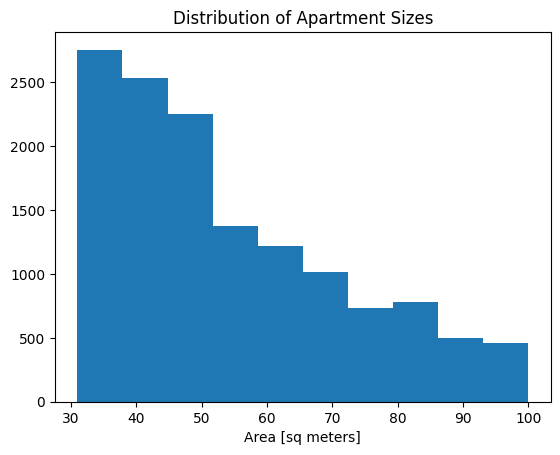

In [ ]:
plt.hist(df["surface_covered_in_m2"])
plt.xlabel("Area [sq meters]")
plt.title("Distribution of Apartment Sizes");

#### 4.4 Relationship with Target

1. Price vs. Area

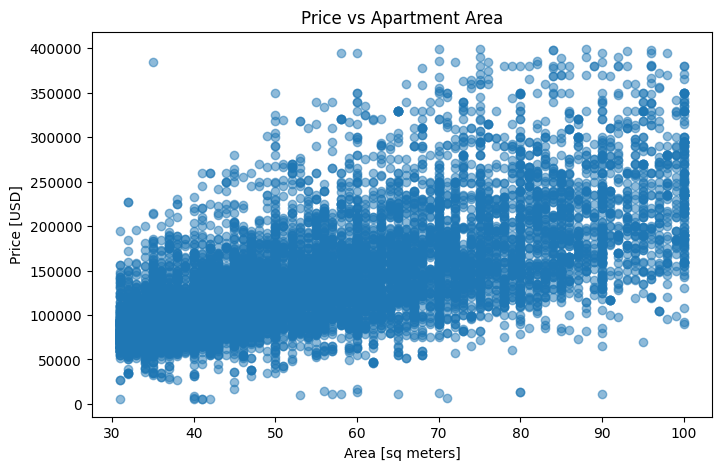

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(x=df["surface_covered_in_m2"], y=df["price_aprox_usd"], alpha=0.5)
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Price vs Apartment Area")
plt.show()

2. Price vs. Location (Map View)

In [ ]:
fig = px.scatter_mapbox(
    df,
    lat="lat",
    lon="lon",
    color="price_aprox_usd",
    width=600,
    height=600,
    hover_data=["place_name", "price_aprox_usd"],
)
fig.update_layout(mapbox_style="open-street-map")
fig.show()

3. Top 10 Neighborhoods by Average Price

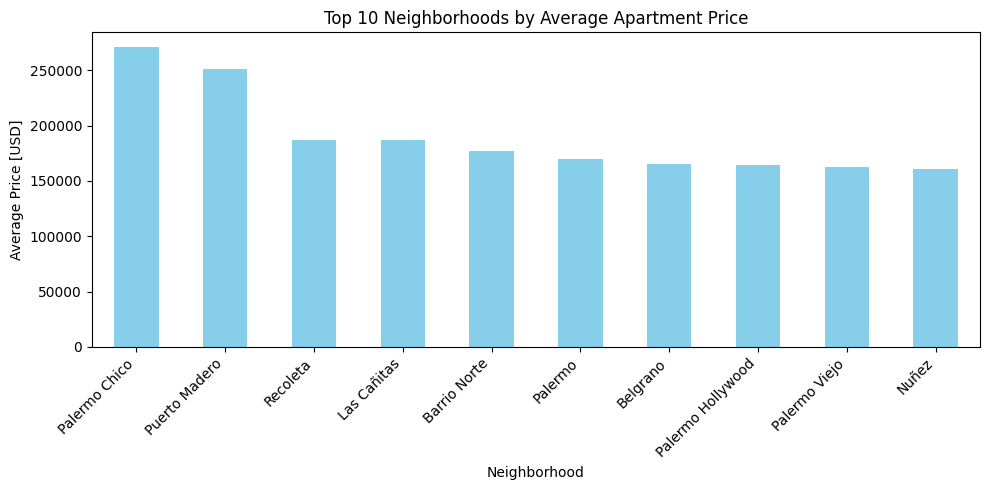

In [ ]:
bar_data = df.groupby("place_name")["price_aprox_usd"].mean().reset_index()

# Sort and plot
bar_data.sort_values(by="price_aprox_usd", ascending=False).head(10).plot(
    kind="bar",
    x="place_name",
    y="price_aprox_usd",
    legend=False,
    figsize=(10,5),
    color="skyblue"
)

plt.xlabel("Neighborhood")
plt.ylabel("Average Price [USD]")
plt.title("Top 10 Neighborhoods by Average Apartment Price")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

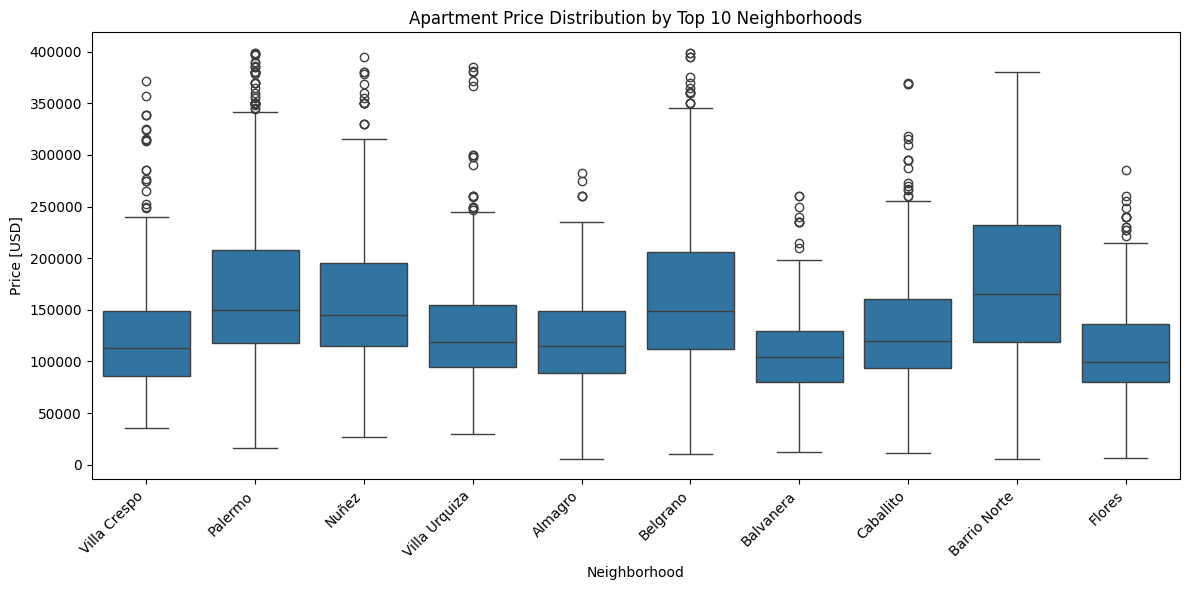

In [ ]:
plt.figure(figsize=(12, 6))
top_neigh = df["place_name"].value_counts().head(10).index
sns.boxplot(data=df[df["place_name"].isin(top_neigh)], x="place_name", y="price_aprox_usd")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Neighborhood")
plt.ylabel("Price [USD]")
plt.title("Apartment Price Distribution by Top 10 Neighborhoods")
plt.tight_layout()
plt.show()

### 5. Split Data

To evaluate our model fairly and tune its performance, we split the dataset into:
- 60% for training the model
- 20% for validation (model tuning)
- 20% for final testing

We use `train_test_split` twice to achieve this distribution.

In [ ]:
# Define target and features
target = "price_aprox_usd"
X = df.drop(columns=target)
y = df[target]

# First split → 80% train_val, 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Second split → 75% of train_val becomes train (60% of total), 25% becomes val (20% of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42
)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (8166, 4)
Validation shape: (2723, 4)
Test shape: (2723, 4)


In [ ]:
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

### 6. Preprocessing: Handling Missing Values & Categorical Features



Our dataset includes both numeric and categorical features with missing values. We apply the following steps:

- **Numeric features**: Median imputation
- **Categorical features**: Most frequent imputation + One-Hot Encoding
- We use a `ColumnTransformer` to apply these transformations in a single preprocessing pipeline.

In [ ]:
# Separate column types
cat_features = X_train.select_dtypes(include="object").columns.tolist()
num_features = X_train.select_dtypes(exclude="object").columns.tolist()

print("Categorical:", cat_features)
print("Numerical:", num_features)


# Numerical pipeline
num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

# Categorical pipeline
cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(use_cat_names=True))  # Keeps original column names
])

# Full preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

Categorical: ['place_name']
Numerical: ['lat', 'lon', 'surface_covered_in_m2']


### 7. Baseline

As a baseline, we predict the average apartment price from the training set for all samples. This helps us evaluate whether future models offer meaningful improvement over a naive guess.

- **Mean price (training set):** $135085.42
- **Baseline Mean Absolute Error (MAE):** 46251.1

A good regression model should achieve **lower MAE than this baseline**.

In [ ]:
# Baseline prediction: use mean of training prices
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)

# Evaluate performance
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)

print(f"Mean apartment price (training set): ${round(y_mean, 2)}")
print(f"Baseline MAE: {round(baseline_mae, 2)}")

Mean apartment price (training set): $135085.42
Baseline MAE: 46251.1


### 8. Iteration Through Models

#### 8.1 First Iteration

In [ ]:
# Store results in a global list
results = []

def train_and_evaluate_model(model, model_name, X_train, y_train, X_val, y_val):
    """
    Builds a pipeline with preprocessing, fits the model, evaluates it,
    and stores performance metrics in the global `results` list.
    """

    # Identify feature types
    cat_features = X_train.select_dtypes(include="object").columns.tolist()
    num_features = X_train.select_dtypes(exclude="object").columns.tolist()

    # Numerical pipeline
    num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median"))
    ])

    # Categorical pipeline
    cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(use_cat_names=True))
    ])

    # Full preprocessor
    preprocessor = ColumnTransformer([
        ("num", num_pipeline, num_features),
        ("cat", cat_pipeline, cat_features)
    ])

    # Full pipeline
    pipeline = Pipeline([
        ("preprocessing", preprocessor),
        ("regressor", model)
    ])

    # Fit model
    pipeline.fit(X_train, y_train)

    # Predict on validation set
    y_pred = pipeline.predict(X_val)

    # Evaluate
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    # Store results
    results.append({
        "Model": model_name,
        "MAE": round(mae, 2),
        "R²": round(r2, 3)
    })

    print(f"{model_name} - MAE: {round(mae, 2)} - R²: {round(r2, 3)}")

    return pipeline

In [ ]:
names = ["Linear Regression",
         "Ridge Regression",
         "Lasso Regression",
         "Random Forest Regressor",
         "Gradient Boosting Regressor"]

# Define the base models
base_models = [LinearRegression(),
               Ridge(),
               Lasso(),
               RandomForestRegressor(),
               GradientBoostingRegressor()]

# Loop through models and names together
for name, model in zip(names, base_models):
    train_and_evaluate_model(model, name, X_train, y_train, X_val, y_val)

Linear Regression - MAE: 24871.85 - R²: 0.659
Ridge Regression - MAE: 24889.51 - R²: 0.657
Lasso Regression - MAE: 24866.81 - R²: 0.659
Random Forest Regressor - MAE: 19322.21 - R²: 0.757
Gradient Boosting Regressor - MAE: 22779.65 - R²: 0.704


In [ ]:
results_df = pd.DataFrame(results)
results_df.sort_values(by="MAE")

,Model,MAE,R²
3,Random Forest Regressor,19322.21,0.757
4,Gradient Boosting Regressor,22779.65,0.704
2,Lasso Regression,24866.81,0.659
0,Linear Regression,24871.85,0.659
1,Ridge Regression,24889.51,0.657


- Best Model So Far: Random Forest Regressor

     * Lowest MAE

     * Highest R²

Captures nonlinear relationships, such as location and neighborhood effects

- Linear Models Performance

All three (Linear, Ridge, Lasso) perform nearly identically — indicating linear relationships do exist but are not sufficient to explain all variance.

- Gradient Boosting

Performs well, slightly worse than Random Forest. Might benefit from hyperparameter tuning.

#### 8.2 Random Forest Hyperparameter Tuning

In [ ]:
# Create the full pipeline: Preprocessor + Random Forest Regressor
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define the parameter grid for GridSearchCV for RandomForestRegressor
param_grid_rf = {
    'regressor__n_estimators': [100, 300], # Number of trees in the forest
    'regressor__max_features': [0.7, 0.9], # Percentage of features to consider when looking for the best split
    'regressor__max_depth': [10, 20, None], # Maximum depth of the tree (None means unlimited)
    'regressor__min_samples_leaf': [1, 5] # Minimum number of samples required to be at each leaf node
}

grid_search_rf = GridSearchCV(
    rf_pipeline,
    param_grid_rf,
    cv=3, # Use 3-fold cross-validation
    scoring='neg_mean_absolute_error', # We want to minimize MAE, so we maximize negative MAE
    verbose=2, # Higher verbosity shows more details during fitting
    n_jobs=-1  # Use all available CPU cores to speed up computation
)

# Fit Grid Search on the training data (X_train, y_train)
grid_search_rf.fit(X_train, y_train)

print(f"Best parameters found: {grid_search_rf.best_params_}")
print(f"Best cross-validation MAE (negative score): {grid_search_rf.best_score_:.4f}")
print(f"Best cross-validation MAE (positive value): {-grid_search_rf.best_score_:.4f}")

# Get the best estimator (the trained pipeline with the best parameters)
best_rf_model = grid_search_rf.best_estimator_

# Make predictions on the validation set using the best model
y_pred_val_rf = best_rf_model.predict(X_val)

# Calculate Mean Absolute Error (MAE)
mae_val_rf = mean_absolute_error(y_val, y_pred_val_rf)
print(f"Mean Absolute Error (MAE) on Validation Set: {mae_val_rf:.2f}")

# Calculate R-squared (R2)
r2_val_rf = r2_score(y_val, y_pred_val_rf)
print(f"R-squared (R2) on Validation Set: {r2_val_rf:.4f}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters found: {'regressor__max_depth': None, 'regressor__max_features': 0.7, 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 300}
Best cross-validation MAE (negative score): -21019.1846
Best cross-validation MAE (positive value): 21019.1846
Mean Absolute Error (MAE) on Validation Set: 19155.26
R-squared (R2) on Validation Set: 0.7609


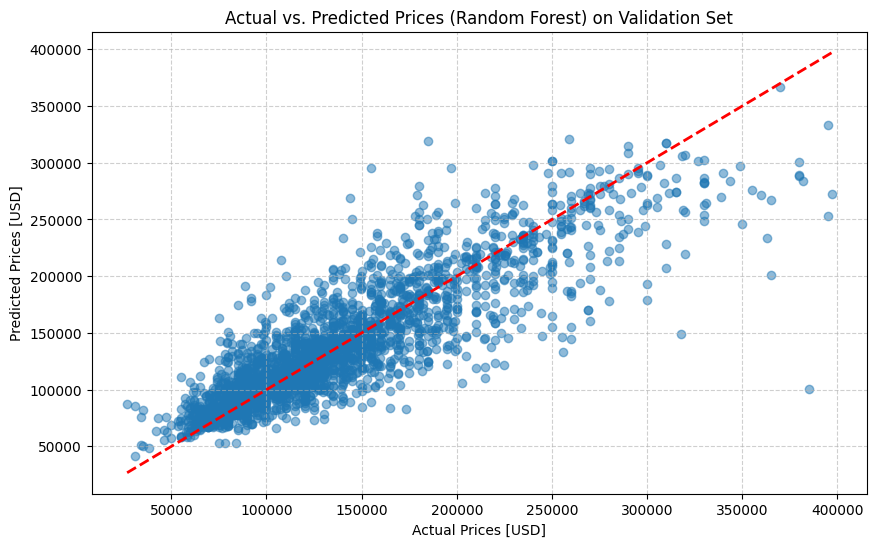

In [ ]:
# Visualize predictions vs actuals
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_val_rf, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2) # y=x line
plt.xlabel("Actual Prices [USD]")
plt.ylabel("Predicted Prices [USD]")
plt.title("Actual vs. Predicted Prices (Random Forest) on Validation Set");
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

#### 8.3 Add Spatial Feature Engineering

8.3.1 Spatial Feature Engineering

In [ ]:
# Define a central point for Capital Federal (e.g., The Obelisco coordinates)
capital_federal_center = (-34.603722, -58.381592) # (latitude, longitude)

def add_spatial_features(df_subset, kmeans_model=None, neighborhood_avg_price_map=None, train_df_for_fit=None, y_train_series_for_fit=None):
    """
    Adds spatial features to a DataFrame subset (X_train, X_val, or X_test).
    Handles fitting KMeans and calculating neighborhood average prices on the training data,
    and then applying those fitted models/maps to all subsets to prevent data leakage.

    Args:
        df_subset (pd.DataFrame): The DataFrame subset to add features to.
        kmeans_model (sklearn.cluster.KMeans, optional): Fitted KMeans model. Required for val/test sets.
        neighborhood_avg_price_map (dict, optional): Mapping of neighborhood to avg price. Required for val/test sets.
        train_df_for_fit (pd.DataFrame, optional): Original X_train DataFrame. Used to fit KMeans
                                                  and calculate neighborhood_avg_price_map when called for X_train.
        y_train_series_for_fit (pd.Series, optional): Original y_train Series. Used to calculate
                                                   neighborhood_avg_price_map when called for y_train.

    Returns:
        pd.DataFrame: DataFrame with new spatial features.
        tuple: (fitted_kmeans_model, fitted_neighborhood_avg_price_map) if called for the training set.
    """
    df_processed = df_subset.copy()

    # --- Feature: Distance to Center ---
    temp_lat = df_processed['lat'].fillna(df_processed['lat'].mean())
    temp_lon = df_processed['lon'].fillna(df_processed['lon'].mean())

    df_processed['distance_to_center'] = [
        geodesic((lat, lon), capital_federal_center).km
        if pd.notna(lat) and pd.notna(lon)
        else np.nan # Keep NaN if original lat/lon were NaN, pipeline imputer will handle
        for lat, lon in zip(temp_lat, temp_lon)
    ]
    print(f"  Added 'distance_to_center'. NaNs: {df_processed['distance_to_center'].isna().sum()}")

    # --- Feature: Neighborhood Average Price (Target Encoding) ---
    if train_df_for_fit is not None and y_train_series_for_fit is not None:
        # Calculate mapping ONLY on training data to prevent leakage
        temp_train_combined = train_df_for_fit.copy()
        temp_train_combined['target'] = y_train_series_for_fit
        neighborhood_avg_price_map = temp_train_combined.groupby('place_name')['target'].mean().to_dict()
        global_avg_price_fallback = y_train_series_for_fit.mean()
        print(f"  Calculated neighborhood_avg_price_map from training data. Global fallback: {global_avg_price_fallback:.2f}")
    else:
        # For validation/test sets, ensure the map is provided
        if neighborhood_avg_price_map is None:
            raise ValueError("For non-training sets, 'neighborhood_avg_price_map' must be provided.")
        pass
    df_processed['neighborhood_avg_price'] = df_processed['place_name'].map(neighborhood_avg_price_map)
    df_processed['neighborhood_avg_price'].fillna(df_processed['neighborhood_avg_price'].mean(), inplace=True)
    print(f"  Added 'neighborhood_avg_price'. NaNs: {df_processed['neighborhood_avg_price'].isna().sum()}")


    # --- Feature: Clustered lat/lon groups ---
    fitted_kmeans_model = kmeans_model
    if fitted_kmeans_model is None and train_df_for_fit is not None:
        # Fit KMeans ONLY on training data's lat/lon (dropna for fitting KMeans)
        kmeans_data_for_fit = train_df_for_fit[['lat', 'lon']].dropna()
        n_clusters = 8 # A common starting point; can be tuned further
        fitted_kmeans_model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        fitted_kmeans_model.fit(kmeans_data_for_fit)
        print(f"  Fitted KMeans model with {n_clusters} clusters on training data.")
    elif fitted_kmeans_model is None:
        raise ValueError("For non-training sets, 'kmeans_model' must be provided.")

    # Predict clusters for the current df_subset
    temp_lat_lon_for_predict = df_processed[['lat', 'lon']].fillna(df_processed[['lat', 'lon']].mean())
    df_processed['lat_lon_cluster'] = fitted_kmeans_model.predict(temp_lat_lon_for_predict)
    print(f"  Added 'lat_lon_cluster'. NaNs: {df_processed['lat_lon_cluster'].isna().sum()}")


    if train_df_for_fit is not None:
        return df_processed, (fitted_kmeans_model, neighborhood_avg_price_map)
    else:
        return df_processed

8.3.2 Starting Spatial Feature Engineering

In [ ]:
# Apply Spatial Feature Engineering to training data first to fit models/maps
X_train_spatial, (kmeans_model_trained, neighborhood_avg_price_map_trained) = add_spatial_features(
    X_train, train_df_for_fit=X_train, y_train_series_for_fit=y_train
)

# Apply trained models/maps to validation data
X_val_spatial = add_spatial_features(
    X_val, kmeans_model=kmeans_model_trained, neighborhood_avg_price_map=neighborhood_avg_price_map_trained
)

# Apply trained models/maps to test data
X_test_spatial = add_spatial_features(
    X_test, kmeans_model=kmeans_model_trained, neighborhood_avg_price_map=neighborhood_avg_price_map_trained
)

print("\nSpatial Feature Engineering Complete for X_train, X_val, X_test.")
print(f"New X_train_spatial shape: {X_train_spatial.shape}")
print(f"New X_val_spatial shape: {X_val_spatial.shape}")
print(f"New X_test_spatial shape: {X_test_spatial.shape}")

# Update numerical and categorical features lists for the ColumnTransformer
numerical_features_new = num_features + ['distance_to_center', 'neighborhood_avg_price']
categorical_features_new = cat_features + ['lat_lon_cluster'] # lat_lon_cluster is now a numerical integer, will be OHE by pipeline

print(f"\nUpdated Numerical Features: {numerical_features_new}")
print(f"Updated Categorical Features: {categorical_features_new}")

  Added 'distance_to_center'. NaNs: 0
  Calculated neighborhood_avg_price_map from training data. Global fallback: 135085.42
  Added 'neighborhood_avg_price'. NaNs: 0
  Fitted KMeans model with 8 clusters on training data.
  Added 'lat_lon_cluster'. NaNs: 0
  Added 'distance_to_center'. NaNs: 0
  Added 'neighborhood_avg_price'. NaNs: 0
  Added 'lat_lon_cluster'. NaNs: 0
  Added 'distance_to_center'. NaNs: 0
  Added 'neighborhood_avg_price'. NaNs: 0
  Added 'lat_lon_cluster'. NaNs: 0

Spatial Feature Engineering Complete for X_train, X_val, X_test.
New X_train_spatial shape: (8166, 7)
New X_val_spatial shape: (2723, 7)
New X_test_spatial shape: (2723, 7)

Updated Numerical Features: ['lat', 'lon', 'surface_covered_in_m2', 'distance_to_center', 'neighborhood_avg_price']
Updated Categorical Features: ['place_name', 'lat_lon_cluster']


8.3.3 Re-run Grid Search for Random Forest with New Spatial Features

In [ ]:
# Redefine preprocessing pipeline with updated feature lists
numerical_transformer_new = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# For categorical features, including the new 'lat_lon_cluster'
categorical_transformer_new = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Using most_frequent for new integer clusters
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_new = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_new, numerical_features_new),
        ('cat', categorical_transformer_new, categorical_features_new)
    ],
    remainder='drop'
)

# Create the full pipeline: Preprocessor + Random Forest Regressor
rf_pipeline_new = Pipeline(steps=[
    ('preprocessor', preprocessor_new),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define the parameter grid for GridSearchCV for RandomForestRegressor (can be adjusted)
param_grid_rf_new = {
    'regressor__n_estimators': [100, 300], # Number of trees in the forest
    'regressor__max_features': [0.7, 0.9], # Percentage of features to consider when looking for the best split
    'regressor__max_depth': [10, 20, None], # Maximum depth of the tree (None means unlimited)
    'regressor__min_samples_leaf': [1, 5] # Minimum number of samples required to be at each leaf node
}

grid_search_rf_new = GridSearchCV(
    rf_pipeline_new,
    param_grid_rf_new,
    cv=3, # Use 3-fold cross-validation
    scoring='neg_mean_absolute_error', # We want to minimize MAE, so we maximize negative MAE
    verbose=2, # Higher verbosity shows more details during fitting
    n_jobs=-1  # Use all available CPU cores to speed up computation
)

# Fit Grid Search on the training data with new spatial features
grid_search_rf_new.fit(X_train_spatial, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['lat',
                                                                          'lon',
                                                                          'surface_covered_in_m2',
                                                                          'distance_to_center',
                                                                          'neighborhood_avg_price']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['place_name',
                                                                          'lat_lon_cluster'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [10, 20, None],
                         'regressor__max_features': [0.7, 0.9],
                         'regressor__min_samples_leaf': [1, 5],
                         'regressor__n_estimators': [100, 300]},
             scoring='neg_mean_absolute_error', verbose=2)

In [ ]:
print(f"Best parameters found: {grid_search_rf_new.best_params_}")
print(f"Best cross-validation MAE (negative score): {grid_search_rf_new.best_score_:.4f}")
print(f"Best cross-validation MAE (positive value): {-grid_search_rf_new.best_score_:.4f}")

# Get the best estimator (the trained pipeline with the best parameters)
best_rf_model_spatial = grid_search_rf_new.best_estimator_

# Make predictions on the validation set using the best model
y_pred_val_rf_spatial = best_rf_model_spatial.predict(X_val_spatial)

# Calculate Mean Absolute Error (MAE)
mae_val_rf_spatial = mean_absolute_error(y_val, y_pred_val_rf_spatial)
print(f"Mean Absolute Error (MAE) on Validation Set: {mae_val_rf_spatial:.2f}")

# Calculate R-squared (R2)
r2_val_rf_spatial = r2_score(y_val, y_pred_val_rf_spatial)
print(f"R-squared (R2) on Validation Set: {r2_val_rf_spatial:.4f}")

Best parameters found: {'regressor__max_depth': 20, 'regressor__max_features': 0.7, 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 300}
Best cross-validation MAE (negative score): -20858.3549
Best cross-validation MAE (positive value): 20858.3549
Mean Absolute Error (MAE) on Validation Set: 18908.74
R-squared (R2) on Validation Set: 0.7714


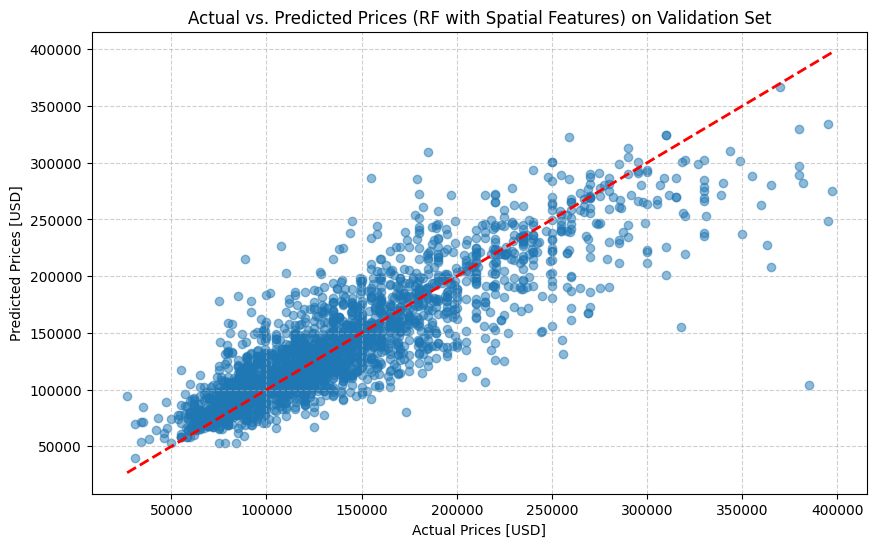


The MAE has decreased and R-squared has increased with the addition of spatial features!


In [ ]:
# Visualize predictions vs actuals
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_val_rf_spatial, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2) # y=x line
plt.xlabel("Actual Prices [USD]")
plt.ylabel("Predicted Prices [USD]")
plt.title("Actual vs. Predicted Prices (RF with Spatial Features) on Validation Set");
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("\nThe MAE has decreased and R-squared has increased with the addition of spatial features!")

### 9. Final Model Evaluation

In [ ]:
# Make predictions on the test set using the best model with spatial features
y_pred_test_rf_spatial = best_rf_model_spatial.predict(X_test_spatial)

# Calculate Mean Absolute Error (MAE) on the test set
mae_test_rf_spatial = mean_absolute_error(y_test, y_pred_test_rf_spatial)
print(f"Mean Absolute Error (MAE) on Test Set: {mae_test_rf_spatial:.2f}")

# Calculate R-squared (R2) on the test set
r2_test_rf_spatial = r2_score(y_test, y_pred_test_rf_spatial)
print(f"R-squared (R2) on Test Set: {r2_test_rf_spatial:.4f}")

Mean Absolute Error (MAE) on Test Set: 19268.38
R-squared (R2) on Test Set: 0.7559


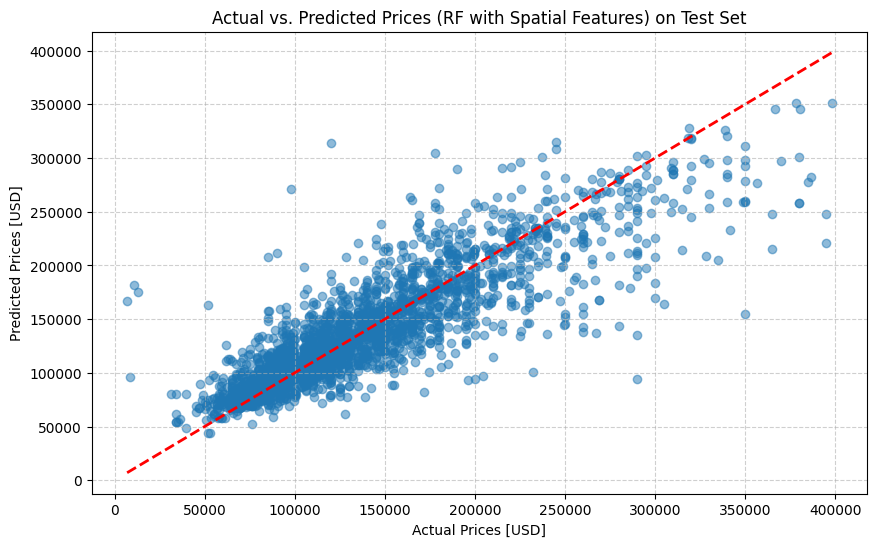

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test_rf_spatial, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # y=x line
plt.xlabel("Actual Prices [USD]")
plt.ylabel("Predicted Prices [USD]")
plt.title("Actual vs. Predicted Prices (RF with Spatial Features) on Test Set");
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

#### Feature Importance

In [ ]:
# Get_feature_names_out() retrieves the names of all transformed features.
feature_names_out = best_rf_model_spatial.named_steps['preprocessor'].get_feature_names_out()

# Get importances from the regressor step of the pipeline
importances = best_rf_model_spatial.named_steps['regressor'].feature_importances_

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'Feature': feature_names_out,
    'Importance': importances
})

# Sort by importance in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Display top N features
n_top_features = 20 # You can adjust this number to see more or fewer top features
print(f"Top {n_top_features} Features by Importance (Mean Decrease in Impurity):")
print(feature_importances_df.head(n_top_features))

Top 20 Features by Importance (Mean Decrease in Impurity):
                        Feature  Importance
2    num__surface_covered_in_m2    0.505620
4   num__neighborhood_avg_price    0.196934
0                      num__lat    0.113958
1                      num__lon    0.079886
3       num__distance_to_center    0.068462
34                    cat__0_30    0.004193
6                      cat__0_2    0.003096
67                     cat__1_2    0.002589
17                    cat__0_13    0.002463
23                    cat__0_19    0.001646
21                    cat__0_17    0.001114
58                    cat__0_54    0.000991
66                     cat__1_1    0.000978
68                     cat__1_3    0.000952
13                     cat__0_9    0.000906
12                     cat__0_8    0.000885
30                    cat__0_26    0.000872
69                     cat__1_4    0.000867
31                    cat__0_27    0.000723
55                    cat__0_51    0.000709


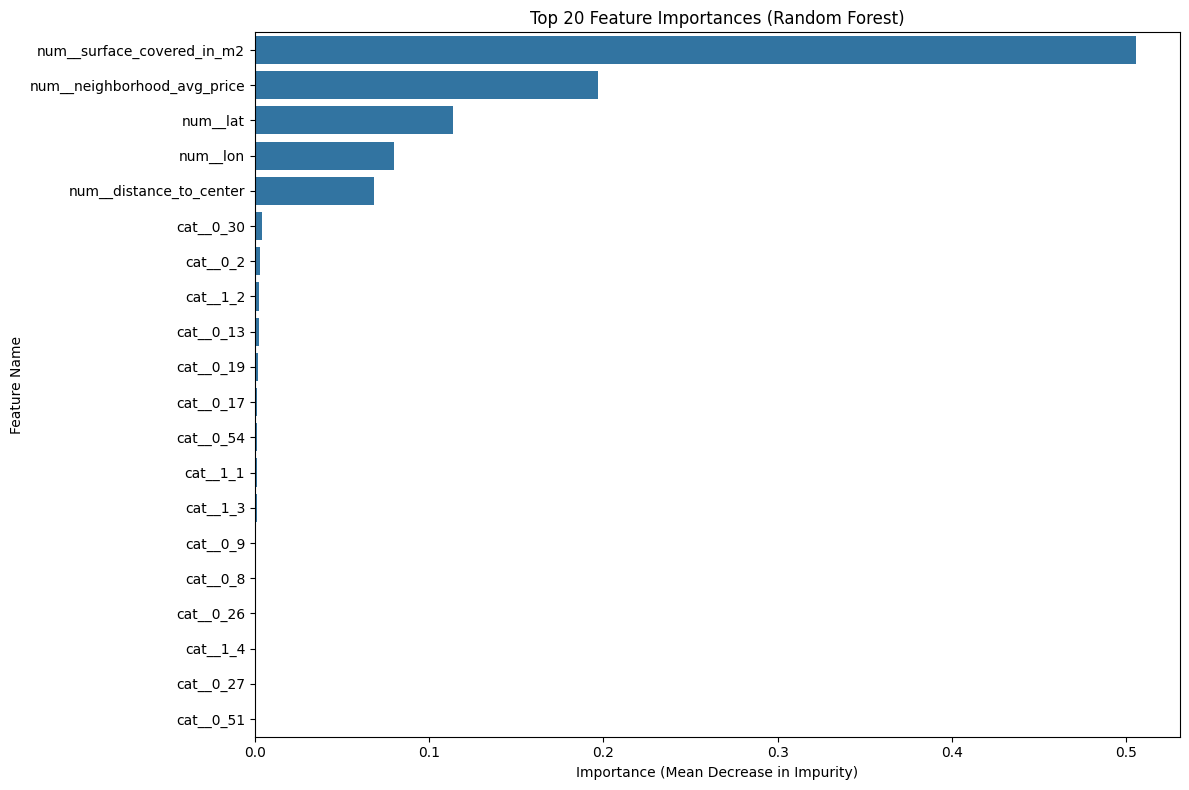

In [ ]:
# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(n_top_features))
plt.title(f'Top {n_top_features} Feature Importances (Random Forest)')
plt.xlabel('Importance (Mean Decrease in Impurity)')
plt.ylabel('Feature Name')
plt.tight_layout() # Adjusts plot to prevent labels from overlapping
plt.show()

The plot clearly shows the most influential factors in your Random Forest Regressor's predictions:

* **`num_surface_covered_in_m2`**: This is overwhelmingly the most important feature, accounting for roughly 50% of the predictive power. This makes intuitive sense, as property size is a primary driver of price.

* **`num_neighborhood_avg_price`**: Our engineered feature is the second most important, which is confirm that including the average price of a neighborhood based on training data significantly enhances the model's ability to predict.

* **`num_lat` and `num_lon`**: Latitude and Longitude are also highly important. This, along with `num_distance_to_center`, confirms the strong spatial component of property valuation.

* **`num_distance_to_center`**: Another one of our engineered spatial features, showing its significant contribution to the model.

* **Categorical Features (`cat_X_Y`)**: While present, the individual one-hot encoded categories (from `place_name` and `lat_lon_cluster`) generally have much lower individual importance compared to the numerical features. Their collective impact can still be substantial, but individual categories don't dominate.

Our feature engineering, particularly `num_neighborhood_avg_price` and `num_distance_to_center`, has paid off by creating highly influential features that the model leverages effectively.

#### Residual Analysis

In [ ]:
# Calculate residuals (the errors: actual value - predicted value)
residuals = y_test - y_pred_test_rf_spatial

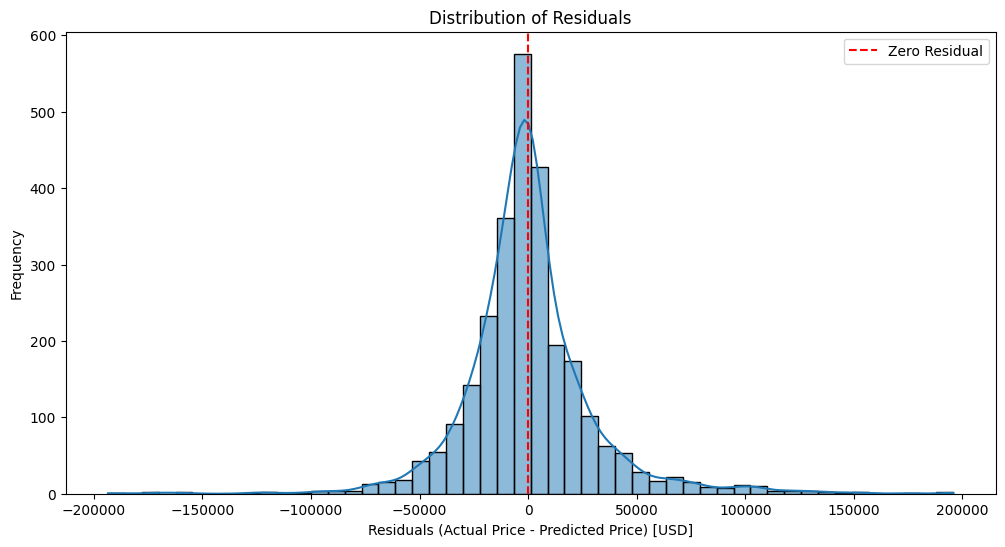

Mean of Residuals: 258.30 USD
Standard Deviation of Residuals: 29851.13 USD
Ideally, residuals should be normally distributed around zero.


In [ ]:
# 1. Histogram of Residuals: Checks the distribution of errors

plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, bins=50) # kde=True shows the estimated probability density function
plt.title('Distribution of Residuals')
plt.xlabel('Residuals (Actual Price - Predicted Price) [USD]')
plt.ylabel('Frequency')
plt.axvline(x=0, color='r', linestyle='--', label='Zero Residual') # Add a line at 0 for reference
plt.legend()
plt.show()

print(f"Mean of Residuals: {residuals.mean():.2f} USD")
print(f"Standard Deviation of Residuals: {residuals.std():.2f} USD")

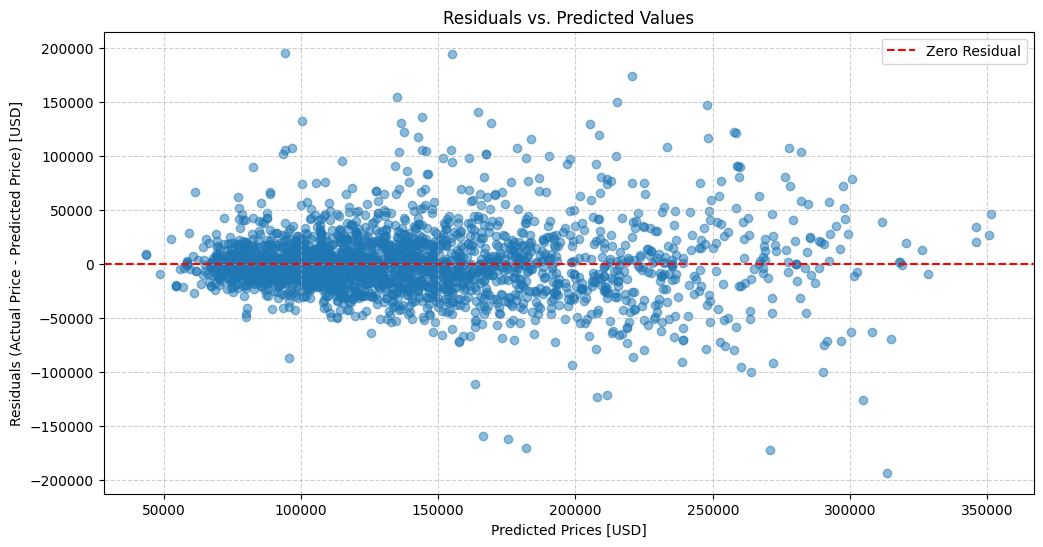

Look for any clear patterns (e.g., a 'fan' shape, or a curve).
A random scatter of points around zero indicates good model performance across the prediction range.


In [ ]:
# 2. Scatter Plot of Predicted Values vs. Residuals: Checks for patterns in errors

plt.figure(figsize=(12, 6))
plt.scatter(y_pred_test_rf_spatial, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Prices [USD]')
plt.ylabel('Residuals (Actual Price - Predicted Price) [USD]')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

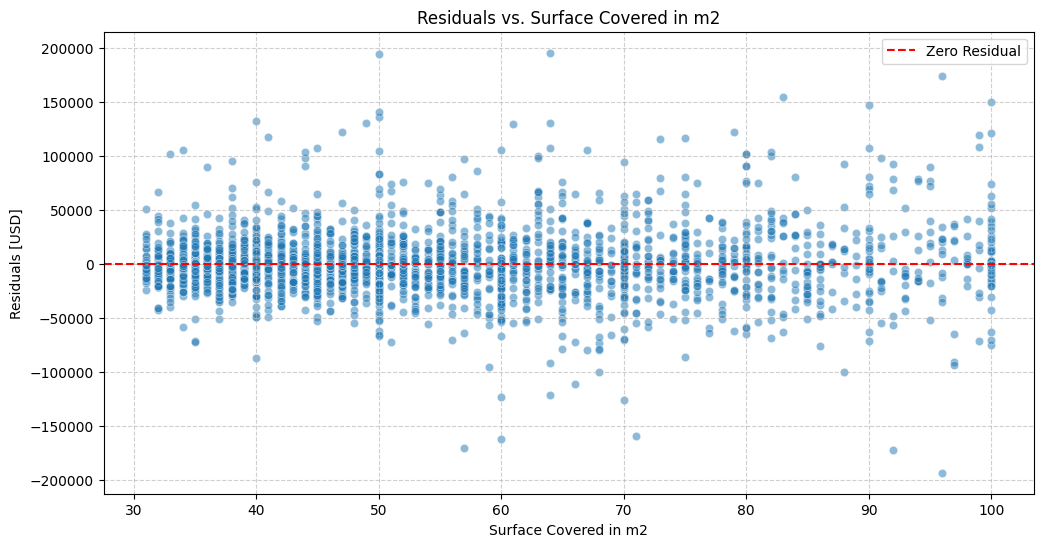

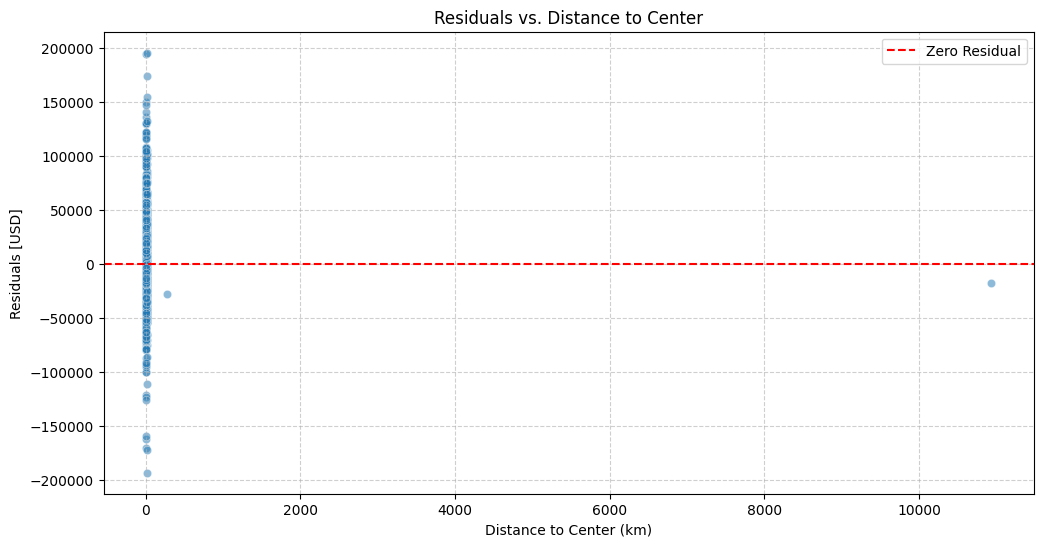

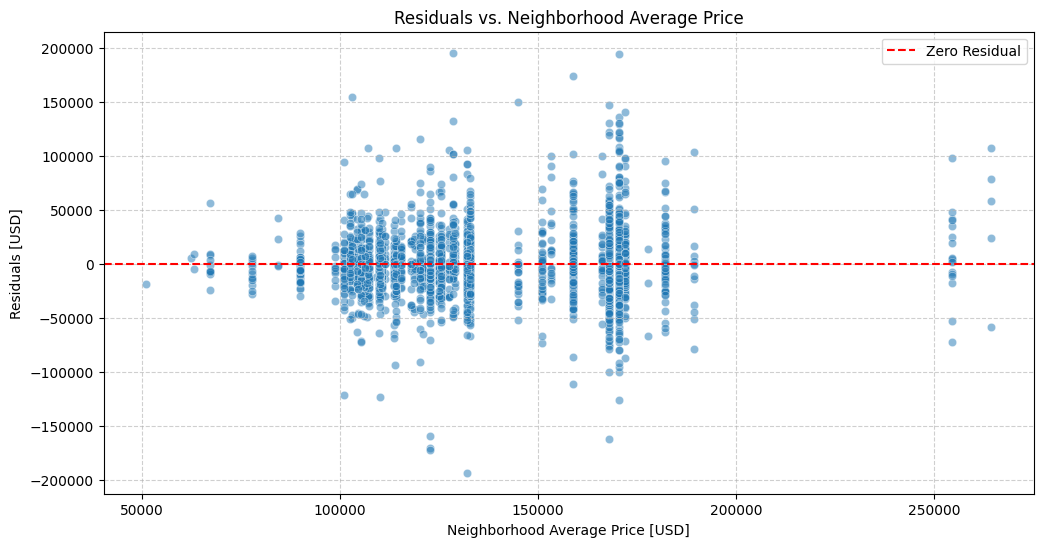

In [ ]:
# 3. Residuals vs. Key Original Features (Optional, for deeper dive)

# For 'surface_covered_in_m2'
if 'surface_covered_in_m2' in X_test_spatial.columns:
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=X_test_spatial['surface_covered_in_m2'], y=residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual')
    plt.title('Residuals vs. Surface Covered in m2')
    plt.xlabel('Surface Covered in m2')
    plt.ylabel('Residuals [USD]')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# For 'distance_to_center' (new spatial feature)
if 'distance_to_center' in X_test_spatial.columns:
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=X_test_spatial['distance_to_center'], y=residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual')
    plt.title('Residuals vs. Distance to Center')
    plt.xlabel('Distance to Center (km)')
    plt.ylabel('Residuals [USD]')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# For 'neighborhood_avg_price' (new spatial feature)
if 'neighborhood_avg_price' in X_test_spatial.columns:
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=X_test_spatial['neighborhood_avg_price'], y=residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual')
    plt.title('Residuals vs. Neighborhood Average Price')
    plt.xlabel('Neighborhood Average Price [USD]')
    plt.ylabel('Residuals [USD]')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

The residual plots reveal how well our model's predictions align with actual values:

* **Distribution of Residuals:** The histogram of residuals shows that our errors are largely centered around zero and follow a roughly bell-shaped (normal) distribution. This is a positive sign, indicating that our model is not systematically biased towards over- or under-prediction on average. However, the tails extend quite far, indicating some large individual errors.

* **Residuals vs. Predicted Values:** This scatter plot is very informative:
    The residuals are centered around the zero line, which is good. However, there's a clear **"fan shape"** or **heteroscedasticity**. This means the spread (variance) of our residuals increases as the predicted price increases. In simpler terms, our model makes larger errors for more expensive properties than for cheaper ones. This is a common issue in regression and can often be addressed.


* **Residuals vs. Distance to Center:** This plot generally shows residuals centered around zero for properties closer to the center.

    * **Crucially, there's a prominent outlier at a distance of ~11,000 km.** This is an extremely large distance for properties within "Capital Federal" and strongly suggests a data error (e.g., incorrect `lat`/`lon` for a property, or a property that somehow slipped into the dataset that is not in Capital Federal). This single point could be disproportionately influencing our model.

Based on these insights, here's what we can focus on next:

1.  **Address Heteroscedasticity with Target Transformation:**
    * The most common and effective way to deal with the "fan shape" in residuals is to **apply a log transformation to our target variable (`price_aprox_usd`)**. Instead of predicting `price_aprox_usd`, we will train our model to predict `log(price_aprox_usd)`.
    
    * This often normalizes the target variable's distribution and stabilizes the variance of residuals, leading to better model performance, especially for higher values.

2.  **Investigate and Handle Data Outlier(s):**
    * The point at ~11,000 km in the "Residuals vs. Distance to Center" plot should be investigated. Locate the row(s) in our `X` data where `distance_to_center` is extremely high.
    We might consider:
        * Removing these extreme outliers from our dataset.
        * Clipping `distance_to_center` to a reasonable maximum if its value beyond a certain threshold should have a limited impact.

By addressing the heteroscedasticity and handling the extreme outlier, we'll likely to see a further improvement in our model's robustness and accuracy across the entire price range.

### Workflow Summary

Our workflow covered essential steps in a machine learning project:

1.  **Data Acquisition and Initial Wrangling:** We started by loading the property data and performing initial cleaning. This involved filtering for `Capital Federal` apartments, handling initial outliers in `lat/lon`, `surface_covered_in_m2`, and `price_aprox_usd` to ensure data quality and relevance.

2.  **Exploratory Data Analysis (EDA):** Through EDA, we gained crucial insights into the data's distributions and relationships. We observed the distribution of prices, the geographic spread of properties, and the strong correlation between price, surface area, and location (`lat`, `lon`, `place_name`). This phase highlighted the importance of spatial features.

3.  **Data Splitting:** We carefully split the data into training, validation, and test sets (`X_train`, `X_val`, `X_test`, and corresponding `y` sets). This crucial step ensured that our model's performance evaluation would be unbiased by data it had already seen.

4.  **Initial Model Comparison:** We set up a foundational preprocessing pipeline (imputation for missing values, scaling for numerical features, and one-hot encoding for categorical features). Using this pipeline, we compared several baseline models, including Linear Regression variants (Lasso, Ridge) and tree-based models (Random Forest Regressor, Gradient Boosting Regressor). The **Random Forest Regressor** emerged as the top performer in this initial comparison.

5.  **Hyperparameter Tuning (Random Forest):** To optimize the Random Forest model, we performed a **Grid Search** across a defined range of hyperparameters (like `n_estimators`, `max_depth`, `max_features`, `min_samples_leaf`). This tuning was guided by minimizing Mean Absolute Error (MAE) on the validation set, leading to a modest improvement in performance.

6.  **Spatial Feature Engineering:** Recognizing the strong spatial patterns in real estate prices, we engineered three impactful new features:
    * **Distance to Center:** Calculated the geodesic distance from each property to a central point in Capital Federal.
    * **Neighborhood Average Price:** Performed target encoding by mapping each neighborhood (`place_name`) to its average price, calculated *only from the training data* to prevent data leakage.
    * **Clustered Lat/Lon Groups:** Applied KMeans clustering to the latitude and longitude coordinates to create new categorical features representing geographical price clusters, again fitted only on training data.
            

7.  **Re-tuning with Spatial Features:** We then integrated these new spatial features into our dataset and re-ran the Random Forest Grid Search. This step significantly improved the model's performance on the validation set, demonstrating the value of well-designed features.
            

8.  **Final Model Evaluation & Diagnostics:** The best model, including the engineered spatial features, was evaluated on the completely unseen **test set** to obtain an unbiased estimate of its real-world performance. We also performed **Feature Importance** analysis to understand which features drove predictions and **Residual Analysis** to diagnose error patterns.

### Conclusion of Results

Our final model, a **Tuned Random Forest Regressor incorporating spatial features**, achieved the following performance metrics on the independent test set:

* **Mean Absolute Error (MAE): 19268.38 USD**
* **R-squared (R²): 0.7559**

This means, on average, our model's predictions are within approximately **\$19,268 USD** of the actual apartment price. The R-squared value indicates that the model explains about **75.6%** of the variance in apartment prices in Capital Federal.

The **Feature Importance** analysis revealed that `surface_covered_in_m2`, `neighborhood_avg_price`, `lat`, `lon`, and `distance_to_center` were the most influential predictors, underscoring the success of the spatial feature engineering.

The **Residual Analysis** showed that while errors are generally centered around zero, there is a clear **heteroscedasticity** (a "fan shape"), indicating that the model's prediction errors tend to be larger for higher-priced properties. An extreme outlier in `distance_to_center` was also identified, suggesting a potential data anomaly.

Overall, the project successfully built a robust model capable of making reasonably accurate apartment price predictions, with clear evidence that feature engineering significantly boosted performance.

### Future Work

To further enhance this project and model, consider the following avenues:

1.  **Address Heteroscedasticity:**
                
     * **Log Transform the Target Variable:** The most effective next step would be to apply a `np.log()` transformation to `price_aprox_usd`. This often stabilizes the variance of residuals and can improve model performance, especially for higher values. Remember to `np.exp()` transform predictions back to the original scale.
                

2.  **Handle Data Outliers/Anomalies More Robustly:**
                    
   * Investigate and decide on the handling of the extreme outlier observed in `distance_to_center`. It might be a data entry error that needs removal or correction. Implementing more formal outlier detection and treatment methods could improve model generalization.
                    

3.  **Explore Other Advanced Models:**
                        
   * Given the success of tree-based models, consider fine-tuning **Gradient Boosting Regressors** (e.g., using libraries like XGBoost or LightGBM) with the newly engineered spatial features. These models often provide superior performance to Random Forests.
                       

4.  **Additional Feature Engineering:**
                           
    * **Temporal Features:** If `created_on` (listing date) or other date information is available in the original dataset, extract features like `month`, `quarter`, or `day_of_week` as real estate markets can have seasonal trends.
                                
  * **Proximity to Amenities:** If external data sources are accessible, consider features like distance to nearest parks, schools, hospitals, or public transport stations.
                                   
 * **Property Characteristics:** If details like number of bedrooms, bathrooms, or property type (e.g., house, condo, duplex) become available, incorporate them as they are strong price drivers.
                                   
5.  **Ensemble Methods:** Combine predictions from multiple well-performing models (e.g., Random Forest and Gradient Boosting) using techniques like stacking or bagging, which can often yield marginal improvements.
                                    

6.  **Model Deployment:** Once satisfied with performance, explore how the model could be integrated into a practical application, such as a web-based price estimator for real estate agents or potential buyers.